Author: Freddie Lloyd

# Part 3: Data Analytics

# Spotify

Spotify is a hugely popular digital audio streaming service that provides access to a huge number of songs, podcasts and other audio formats. 

This project will analyse song data obtained from the Spotify web API via the Spotipy Python library. Spotify provide a well-maintained API with a wide range of endpoints to access different types of data, and Spotipy is a wrapper for the API, allowing users to access all of the features in Python.

To obtain data, a Spotify Developer account is needed, which can done with a free account. Through this, an app can be made, which subsequently provides a client ID and client secret.

Using the obtained client ID and secret ID to authenticate credentials, data can be queried from the Spotify API's endpoints.

In [1]:
# Import libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LinearRegression
# Ignore deprecated warings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.facecolor'] = '#00000000'

In [2]:
# Configures matplotlib to show figures embedded in the notebook
%matplotlib inline

In [3]:
# Authenticate client credentials flow to allow access to data
SPOTIPY_CLIENT_ID = '6707ce712ade4311b1970b5676fb226e'
SPOTIPY_CLIENT_SECRET = '7f4a7afd967f4c39aa88d8a55dfa4a94'

client_credentials_manager = SpotifyClientCredentials(SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Step 1: Data Collection

Having authenticated the credentials, the next step is to retrieve the data. To do this, a function is created that utilises two of the Spotify API's end points: search and audio features. The results of each are returned in JSON format, so were first reduced to the main variables of interest in a Pandas data frame. A single data frame was then created, merging the two results using the track id of each song.

In [ ]:
def get_years_songs(years):
    """
    Inputs a year or range of years and returns a data
    frame containing comprehensive information about songs from
    that year or range of years.

    Parameters: 
        years - The year or range of years to search for

    Returns:
        songs_info - A data frame containing all variables of interest
    """  
    
    # Retrieve base information of songs
    artist = []
    track_name = []
    track_id = []
    release_date = []
    track_length = []
    explicit = []
    popularity = []
    
    # Search endpoint has a 50 result limit, so loop over it to return 1000 results per search.
    for i in range(0, 1000, 50):
        
        years_songs = sp.search(q='year:' + years, type='track', limit = 50, offset = i)

        for item in years_songs['tracks']['items']:
            
            artist.append(item['artists'][0]['name'])
            track_name.append(item['name'])
            track_id.append(item['id'])
            release_date.append(item['album']['release_date'])
            track_length.append(item['duration_ms'])
            explicit.append(item['explicit'])
            popularity.append(item['popularity'])
                           
    songs_base_info = pd.DataFrame({'decade' : years,
                                    'artist' : artist,
                                    'song' : track_name,
                                    'track id' : track_id,
                                    'release date' : release_date,
                                    'song length (ms)' : track_length,
                                    'explicit' : explicit,
                                    'popularity' : popularity})
    
    
    # Retrieve audio features of each of the songs returned in the search query.
    acousticness = []
    danceability = []
    energy = []
    instrumentalness = []
    key = []
    liveness = []
    loudness = []
    mode = []
    speechiness = []
    tempo = []
    time_signature = []
    valence = []
    
    track_ids = songs_base_info['track id']  

    for song_id in track_ids:

        song_audio_features = sp.audio_features(song_id)
        
        if song_audio_features[0] != None:
            
            # Append metrics
            acousticness.append(song_audio_features[0]['acousticness'])
            danceability.append(song_audio_features[0]['danceability'])
            energy.append(song_audio_features[0]['energy'])
            instrumentalness.append(song_audio_features[0]['instrumentalness'])
            key.append(song_audio_features[0]['key'])
            liveness.append(song_audio_features[0]['liveness'])
            loudness.append(song_audio_features[0]['loudness'])
            mode.append(song_audio_features[0]['mode'])
            speechiness.append(song_audio_features[0]['speechiness'])
            tempo.append(song_audio_features[0]['tempo'])
            time_signature.append(song_audio_features[0]['time_signature'])
            valence.append(song_audio_features[0]['valence'])
            
        # In case song returned with no audio features available    
        elif song_audio_features[0] == None:
            
            acousticness.append('N/A')
            danceability.append('N/A')
            energy.append('N/A')
            instrumentalness.append('N/A')
            key.append('N/A')
            liveness.append('N/A')
            loudness.append('N/A')
            mode.append('N/A')
            speechiness.append('N/A')
            tempo.append('N/A')
            time_signature.append('N/A')
            valence.append('N/A')

    songs_audio_info = pd.DataFrame({'track id' : track_ids,
                                     'acousticness' : acousticness,
                                     'danceability' : danceability,
                                     'energy' : energy,
                                     'instrumentalness' : instrumentalness,
                                     'key' : key,
                                     'liveness' : liveness,
                                     'loudness' : loudness,
                                     'mode' : mode,
                                     'speechiness' : speechiness,
                                     'tempo' : tempo,
                                     'time signature' : time_signature,
                                     'valence' : valence})
    

    # Combine base info with audio features info by merging on track ID
    songs_info = pd.merge(songs_base_info, songs_audio_info)
    
    return songs_info

###### Basic Information

The search endpoint receives a query value to search for, which can take many forms such as artist or album name, song title, or year of release. Additionally a type can be specified for further granularity, as well as a default limit of 50 songs per search. The search endpoint returns various kinds of data on the query. 


The query was configured to return songs by the inputted year of release then reduced to just the required variables, which are mainly basic information on each song. The variables taken are defined as follows:

- Artist - The artist who released the song.
- Song - The name of the song.
- Popularity - The current popularity of a song, given a value between 0-100 where 100 is the most popular.
- Release Date - The date of the first release of the album containing the song.
- Song Length - The song length in milliseconds.
- Explicit - Whether the song has explicit lyrics. False means it does not or it is unknown.
- Track ID - The ID associated with the song.

###### Audio Features

After this, the audio features from eack song were retrieved, using the track ids from the search query as an argument. Spotify provides various metrics in the audio features endpoint, derived from their own internal algorithms. Whilst it would be better to know the exact derivation of these metrics, they should still provide a reasonable basis for analysis.

The metrics are defined by Spotify as follows:

- Acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
<br>
- Danceability - Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
<br>
- Energy - A measure from 0.0 to 1.0 and representing a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
<br>
- Instrumentalness - Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
<br>
- Key - The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
<br>
- Liveness - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
<br>
- Loudness - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
<br>
- Mode - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
<br>
- Speechiness - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
<br>
- Tempo - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
<br>
- Time Signature - An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". 
<br>
- Valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

To collect data for different years, another function was written to call the get_years_songs function for different time periods. Decades were chosen as the time frame, although there is also a release date variable specifiying the exact date, so there will still be access to more granular time data if needed.

In [ ]:
def concat_decades(decades):
    """
    Inputs a list of decades and calls the get_years_songs
    function for each before combining them into a single
    data frame.

    Parameters: 
        decades - The decade to retrieve song information for

    Returns:
        decades_final - A data frame containing every decades
        song information.
    """  
    
    decades_songs = []

    for decade in decades:
        
        top_50_decade_songs = get_years_songs(decade)
        
        decades_songs.append(top_50_decade_songs)
        
    decades_final = pd.concat(decades_songs)
    
    return decades_final

Each individual decade is brought together into the same data frame, and written to a csv file.

In [ ]:
decades = ["1900-1909",
           "1910-1919",
           "1920-1929",
           "1930-1939",
           "1940-1949",
           "1950-1959",
           "1960-1969",
           "1970-1979",
           "1980-1989",
           "1990-1999",
           "2000-2009",
           "2010-2019",
           "2020-2029"]

spotify_dataset = concat_decades(decades)

# Export data frame as csv
spotify_dataset.to_csv("spotify_dataset.csv", sep = ',')

## Step 2: Data Preparation & Cleaning

In [4]:
# Load the dataset into a dataframe
spotify_dataset = pd.read_csv('spotify_dataset.csv')

In [5]:
# Examine the first 5 rows
spotify_dataset.head()

,Unnamed: 0,decade,artist,song,track id,release date,song length (ms),explicit,popularity,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
0,0,1900-1909,Peter Gabriel,Sledgehammer,3wLZ69kr5J2sb934Kpv02c,1900,295653,False,44,0.0351,...,0.620,0.000000,8.0,0.1530,-8.146,1.0,0.0293,96.392,4.0,0.6260
1,1,1900-1909,Royal Bliss,I Was Drunk,1SbSX9AWecOf7v0CFTHZ4Q,1900,243840,False,41,0.0030,...,0.462,0.000000,1.0,0.3130,-9.165,1.0,0.0304,187.510,3.0,0.2610
2,2,1900-1909,Roy Brown,Mighty Mighty Man,5tBDBrsPypLVJ9Rbpy3MNm,1900-01-30,143230,False,42,0.8240,...,0.374,0.000000,0.0,0.5810,-15.127,0.0,0.0392,106.456,4.0,0.8200
3,3,1900-1909,Peter Gabriel,Mercy Street,20tRwxVyguyMwijkNtH8oP,1900,283373,False,37,0.4730,...,0.192,0.000005,1.0,0.0805,-20.742,0.0,0.0358,92.712,4.0,0.0431
4,4,1900-1909,Peter Gabriel,Shaking The Tree,5XZVeiIA5zPA2VLDFAjvLn,1900,384493,False,35,0.0364,...,0.543,0.000930,1.0,0.0602,-10.884,1.0,0.0353,81.006,4.0,0.6940


In [6]:
spotify_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        13000 non-null  int64  
 1   decade            13000 non-null  object 
 2   artist            13000 non-null  object 
 3   song              13000 non-null  object 
 4   track id          13000 non-null  object 
 5   release date      13000 non-null  object 
 6   song length (ms)  13000 non-null  int64  
 7   explicit          13000 non-null  bool   
 8   popularity        13000 non-null  int64  
 9   acousticness      12994 non-null  float64
 10  danceability      12994 non-null  float64
 11  energy            12994 non-null  float64
 12  instrumentalness  12994 non-null  float64
 13  key               12994 non-null  float64
 14  liveness          12994 non-null  float64
 15  loudness          12994 non-null  float64
 16  mode              12994 non-null  float6

Initial observations:

- Index from each csv has been read as first column - this is the decade index (out of 1000) of a song, but does not represent anything numerically, so can be removed.
- Some modern songs in the '1900-1909' decade appear to have mistakenly been given release date at start of century.
- It would be easier to understand song length in minutes rather than milliseconds.
- Key, mode and time signature are nominal categorical variables - their given value does not represent anything numerically.
- It appears that there are 6 rows with null values for the audio features, but this needs to be checked.

In [7]:
# Remove the index column
spotify_dataset = spotify_dataset.drop(columns = ['Unnamed: 0'])

# Rename the song length column
spotify_dataset.rename(
    columns={
        'song length (ms)' : 'song length (mins)'
    }, inplace=True)

# Change song length to be given in minutes
spotify_dataset['song length (mins)'] = (spotify_dataset['song length (mins)']/1000)/60

# Change data type of nominal categorical variables
spotify_dataset['key'] = spotify_dataset['key'].astype('category')
spotify_dataset['mode'] = spotify_dataset['mode'].astype('category')
spotify_dataset['time signature'] = spotify_dataset['time signature'].astype('category')

It looks like there is 6 rows with missing values for the audio features, but we need to  subset the dataset to check that this is the case, rather than there being NaN's in different columns for more than 6 rows that coinidentally sum to 6 for every variable.

In [8]:
# Return rows with least one missing value in any column
spotify_dataset[spotify_dataset.isnull().any(axis=1)]

,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
480,1900-1909,White Noise Relaxation,Fan Oscillations,3jKWsUsrd4FlLaafnmyJ6c,1900-01-01,2.752333,False,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,1900-1909,Fermin Spanish Guitar,Verano Caluroso,5NXRaohgbJEMbtRdA3Zwsu,1900-01-01,3.525317,False,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1232,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To Bob - Classical,57FhmUFCw3Onjj5QqCXRez,1912,0.527817,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1465,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To Mark - Classical,4uKCp1UriqqFKespsU1RlM,1912,0.527817,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1536,1910-1919,Jerzy Żuławski,Chapter 21.4 - Trylogia księżycowa 2: Zwycięzca,0MqTTtsWO9hOIArg8G9knf,1910,3.113333,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2853,1920-1929,Ruth Etting,What Do We Do on a Dew-Dew-Dewy Day,2UWl0RM3ZLPI2RLsWAHsJG,1926-11-26,2.798883,False,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The assumption that the null values came from 6 rows turned out to be correct. These rows are not contributing much to the data, and may prove troublesome later, so we remove them at this point.

In [9]:
# Drop any rows with NaN values
spotify_dataset = spotify_dataset.dropna(axis = 0)

We now look at the 1900-1909 decade in detail to examine why there appears to be modern songs in this decade.

In [10]:
# Subset dataset to 1900-1909 decade
first_decade = spotify_dataset[spotify_dataset['decade'] == '1900-1909'] 

first_decade.sample(10)

,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
101,1900-1909,Henry Purcell,"Purcell / Arr. Pluhar: The Fairy Queen, Z. 629...",2hGkRokGsegmTzgPpzY7Rx,1900,4.673550,False,27,0.8810,0.482,0.1530,0.061100,2.0,0.1120,-19.288,0.0,0.0425,118.656,3.0,0.4410
599,1900-1909,Brendan Grace,Ringsend Rose - Live,3O5IyDIMkpNamWcwcxPBQT,1909-06-18,4.004433,False,13,0.8660,0.361,0.2590,0.000002,4.0,0.9570,-14.516,1.0,0.0370,132.937,4.0,0.3250
645,1900-1909,Yoga Music,Strangers,6i6mEVk1awtPMCgESvg7up,1900-01-01,4.460000,False,7,0.8750,0.387,0.3890,0.942000,3.0,0.1090,-13.233,1.0,0.0337,99.980,4.0,0.0336
36,1900-1909,Lecuona Cuban Boys,Tabú,0h6M5YPjESxmQ9tJ33iNPP,1909,3.160000,False,31,0.9630,0.686,0.3730,0.088300,4.0,0.1300,-16.429,0.0,0.0411,73.008,4.0,0.6070
342,1900-1909,Xiomara Laugart,Yo no te pido,0Z9YZQwyuDE4NOiQHD4iRB,1905-06-30,3.565100,False,7,0.5760,0.565,0.3990,0.000018,4.0,0.4320,-8.696,1.0,0.0308,115.252,4.0,0.2260
92,1900-1909,Los Papines,Baila mi Yambú,7AxE0TRgq7oJXnPe7JISql,1905-06-30,5.114433,False,19,0.2680,0.567,0.9120,0.227000,8.0,0.1180,-9.834,1.0,0.0868,102.607,4.0,0.8060
482,1900-1909,Ocean Sounds,Drone and Waves,2BQ5hivb8mKMnMMp4JJfje,1900-01-01,1.878633,False,1,0.0495,0.158,0.5220,0.918000,10.0,0.6440,-17.899,0.0,0.0569,97.580,3.0,0.0304
729,1900-1909,Bob Crosby,The Lady's In Love With You,1aqfVORHFi769nfE1XYiyj,1900-01-29,2.635667,False,2,0.9960,0.539,0.1340,0.945000,5.0,0.2290,-21.140,1.0,0.0459,180.581,4.0,0.5800
241,1900-1909,Tony Rich,Mighty Redeemer,41UtGSy2Ddj2ZrqzY9On7r,1909-06-01,3.392217,False,7,0.3120,0.685,0.5240,0.000000,9.0,0.0457,-7.692,1.0,0.0387,145.531,4.0,0.5670
845,1900-1909,Lucy Maud Montgomery,Chapter 151.2 - Anna ystävämme,1TfMV2y3iRKfyWulioWwjh,1909,3.118333,False,0,0.8640,0.638,0.0524,0.000004,3.0,0.1220,-21.259,1.0,0.9440,82.871,4.0,0.5850


A surprising amount of songs in the decade appear to have a release date of exactly '1900-01-01' or just the year 1900. We look at value counts to check this.

In [11]:
first_decade['release date'].value_counts()

1900-01-01    171
1900          124
1900-01-29    100
1900-01-30     85
1905-06-10     61
             ... 
1909-06-19      1
1905-05-16      1
1909-07-01      1
1900-05-07      1
1905-05-30      1
Name: release date, Length: 65, dtype: int64

Looking at the value count from the release date variable for the decade '1900-1909', we can see that only almost 300 songs from the decade have the release date of the first of january 1900, or just the year 1900.

A name that seems to feature regularly is Peter Gabriel, singer of the rock band Genesis in the 1970's, so we subset for his name within the decade, and check the value counts of the release date.



In [12]:
first_decade[first_decade['artist'] == 'Peter Gabriel']['release date'].value_counts()

1900    16
Name: release date, dtype: int64

We see that Peter Gabriel has 16 songs given the release date of 1900. This could likely be an album that has mistakenly been given an incorrect release date. Subsequently, it appears safe to assume that the majority, if not all, of the songs with this release date, or 01/01/1900, are incorrect. 

Whilst just these two release dates could be removed, this would result in an uneven comparison of the number of songs from each decade, as they make up almost a third of the songs in this decade. Consequently, the decision is made to remove this decade from the data.

In [13]:
# Drop the 1900-1909 decade from the dataset
spotify_dataset = spotify_dataset[spotify_dataset['decade'] != '1900-1909']

Next, we need to account for the fact that songs can appear on different albums, which are considered independent in the Spotify search endpoint. We group the data by artist and song to identify any cases which are repeated twice or more.

In [14]:
# Group songs by artist and song to check for duplicates
duplicates = spotify_dataset.groupby(['artist','song'], as_index=True).size()

duplicates[duplicates > 1]

artist                        song                                             
2Pac                          California Love - Original Version                   2
311                           Amber                                                2
AC/DC                         You Shook Me All Night Long                          2
Aaliyah                       Are You That Somebody                                2
Adele                         Easy On Me                                           2
                                                                                  ..
WILLOW                        t r a n s p a r e n t s o u l feat. Travis Barker    2
Warrant                       Cherry Pie                                           2
Wheatus                       Teenage Dirtbag                                      2
Woody Herman & His Orchestra  Let It Snow! Let It Snow! Let It Snow!               2
blackbear                     idfc                                    

In [15]:
duplicates[duplicates > 1].value_counts()

2     424
3      51
4      10
8       2
6       2
9       1
12      1
7       1
5       1
dtype: int64

There are 493 duplicates in the data, which feature exactly the same artist and song combination. However, this also includes cases where there are 3 or more identifical artist/song combinations so the actual number of duplicates is higher than 493. A quick calculation reveals this figure as 609 rows.

In [16]:
# Number of duplicate rows
(1*424)+(2*51)+(3*10)+(7*2)+(5*2)+8+11+6+4

609

We subset the data frame to the Adele song seen above to examine the duplicates further.

In [17]:
adele = spotify_dataset[spotify_dataset['artist'] == 'Adele']

adele[adele['song'] == 'Easy On Me']

,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
12005,2020-2029,Adele,Easy On Me,0gplL1WMoJ6iYaPgMCL0gX,2021-10-14,3.7449,False,98,0.578,0.604,0.366,0.0,5.0,0.133,-7.519,1.0,0.0282,141.981,4.0,0.13
12070,2020-2029,Adele,Easy On Me,46IZ0fSY2mpAiktS3KOqds,2021-11-19,3.7449,False,92,0.578,0.604,0.366,0.0,5.0,0.133,-7.519,1.0,0.0282,141.981,4.0,0.13


We can see that duplicate songs are identical in all variables other than release date and popularity, so the extra song is not contributing anything. As a result, we drop them from the dataset.

In [18]:
# Drop duplicate rows from data, default argument keeps the first found row 
spotify_dataset = spotify_dataset.drop_duplicates(['artist', 'song'])

**Summary:**

In [19]:
spotify_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11387 entries, 1000 to 12999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   decade              11387 non-null  object  
 1   artist              11387 non-null  object  
 2   song                11387 non-null  object  
 3   track id            11387 non-null  object  
 4   release date        11387 non-null  object  
 5   song length (mins)  11387 non-null  float64 
 6   explicit            11387 non-null  bool    
 7   popularity          11387 non-null  int64   
 8   acousticness        11387 non-null  float64 
 9   danceability        11387 non-null  float64 
 10  energy              11387 non-null  float64 
 11  instrumentalness    11387 non-null  float64 
 12  key                 11387 non-null  category
 13  liveness            11387 non-null  float64 
 14  loudness            11387 non-null  float64 
 15  mode                11387 non-nul

- The dataset has 20 columns and 11387 rows, having originally had 1000 rows from each of 12 decades after the removal of 1900-1909.
- There are no null values remaining in the data as rows that did not have audio features were removed.
- Key, mode and time signature are nominal categorical data so have been encoded as numbers to represent the categories.
- 609 duplicate rows were found that were removed as they are identical in audio features.


## Step 3: Exploratory Analysis

Before asking any questions of the data, it is  important to explore the distributions of variables through visualisation to begin to understand the full picture of the data.

**Categorical Variables**

We first explore the distributions of look at the categorial variables, which are best visualised with pie charts or bar charts depending on the number of categories. The categorical variables here are whether a song is explicit, and its mode, key, and time signature.

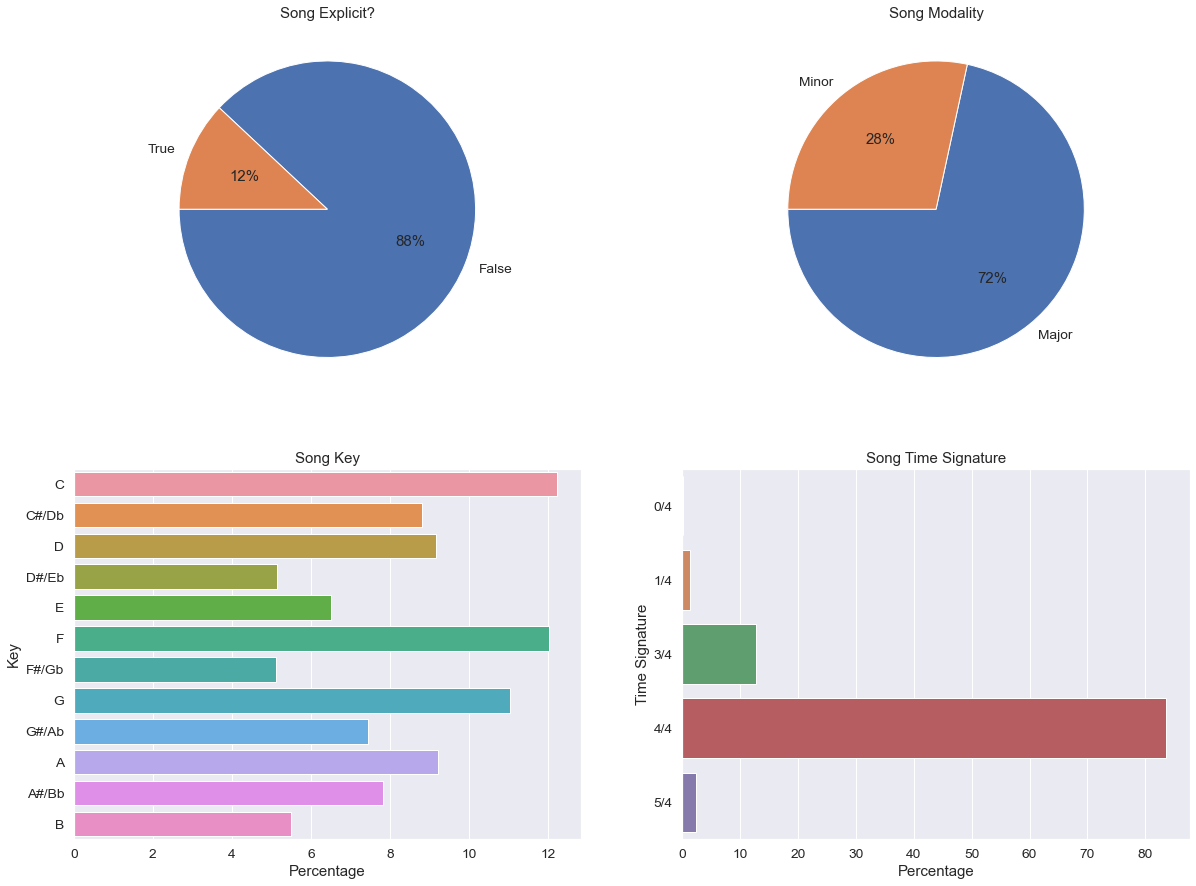

In [20]:
# Create key names dict so can label in their musical form
key_names = {0 : "C", 1 : "C#/Db", 2 : "D", 3 : "D#/Eb", 4 : "E", 5 : "F",
             6 : "F#/Gb", 7 : "G", 8 : "G#/Ab", 9 : "A", 10 : "A#/Bb", 11 : "B"}
# Create time signature names dict so can label in their musical form
signature_names = {0.0 : "0/4", 1.0 : "1/4", 3.0 : "3/4", 4.0 : "4/4", 5.0 : "5/4"}

# Retrieve relevant information for plotting each categorical variable
explicit_counts = spotify_dataset['explicit'].value_counts()
mode_counts = spotify_dataset['mode'].value_counts()
key_counts_pct = (spotify_dataset['key'].value_counts()/spotify_dataset['key'].count())*100
signature_counts_pct = (spotify_dataset['time signature'].value_counts()/spotify_dataset['time signature'].count())*100

sns.set(font_scale = 1.25)
fig, ax = plt.subplots(2, 2, figsize = (20,15))
ax[0,0].pie(explicit_counts, labels=explicit_counts.index, autopct='%1.f%%', startangle=180), ax[0,0].title.set_text('Song Explicit?')
ax[0,1].pie(mode_counts, labels=('Major', 'Minor'), autopct='%1.f%%', startangle=180), ax[0,1].title.set_text('Song Modality')
sns.barplot(y = key_counts_pct.index, x = key_counts_pct, ax=ax[1,0]), ax[1,0].set(xlabel='Percentage', ylabel="Key", yticklabels = key_names.values(), title='Song Key')
sns.barplot(y = signature_counts_pct.index, x = signature_counts_pct, ax=ax[1,1]), ax[1,1].set(xlabel='Percentage', ylabel="Time Signature", yticklabels = signature_names.values(), title='Song Time Signature')

plt.show()

From these charts we can see that the most common combination of explicitness, modality and time signature is non-explicit, major, and a time signature of 4/4. Song key is much more distributed, with only 3 keys making up over 10% of the total songs: C, F and G.

**Numeric variables**

Now also need to explore the distributions of the numeric variables. To do this we firstly look at the describe() function giving summary statistics for each variable, before plotting the histogram of each.

In [21]:
spotify_dataset.describe()

,song length (mins),popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000
mean,3.484068,49.280759,0.501979,0.583340,0.472355,0.107033,0.188015,-10.974812,0.126727,117.885396,0.547979
std,1.478885,28.206662,0.369815,0.166367,0.254898,0.259557,0.146833,5.291431,0.219681,31.411018,0.247048
min,0.512767,0.000000,0.000001,0.000000,0.000020,0.000000,0.015700,-40.449000,0.000000,0.000000,0.000000
25%,2.810342,19.000000,0.114000,0.477000,0.261000,0.000000,0.097100,-13.774500,0.034800,94.001000,0.354000
50%,3.253333,61.000000,0.523000,0.606000,0.461000,0.000025,0.132000,-10.296000,0.046000,114.823000,0.560000
75%,3.985050,72.000000,0.880000,0.704000,0.679000,0.008635,0.237000,-6.930500,0.085200,136.825000,0.747000
max,42.088217,100.000000,0.996000,0.988000,0.999000,1.000000,0.982000,0.844000,0.968000,220.099000,0.991000


Observations:
- The maximum song length of over 42 minutes needs examining.
- Popularity ranges from 0-100, so the mean of 50 with standard deviation of 28 seems to represent a good range of data to analyse this metric on, though the median is 61.
- Acousticness, danceabiity, energy, instrumentalness, liveness, speechiness and valence are calculated variables, ranging from 0-1.
- Loudness (db) and tempo (bpm) are measured continuous variables, with their own unique ranges.

We first plot histograms to examine the distributions visually.

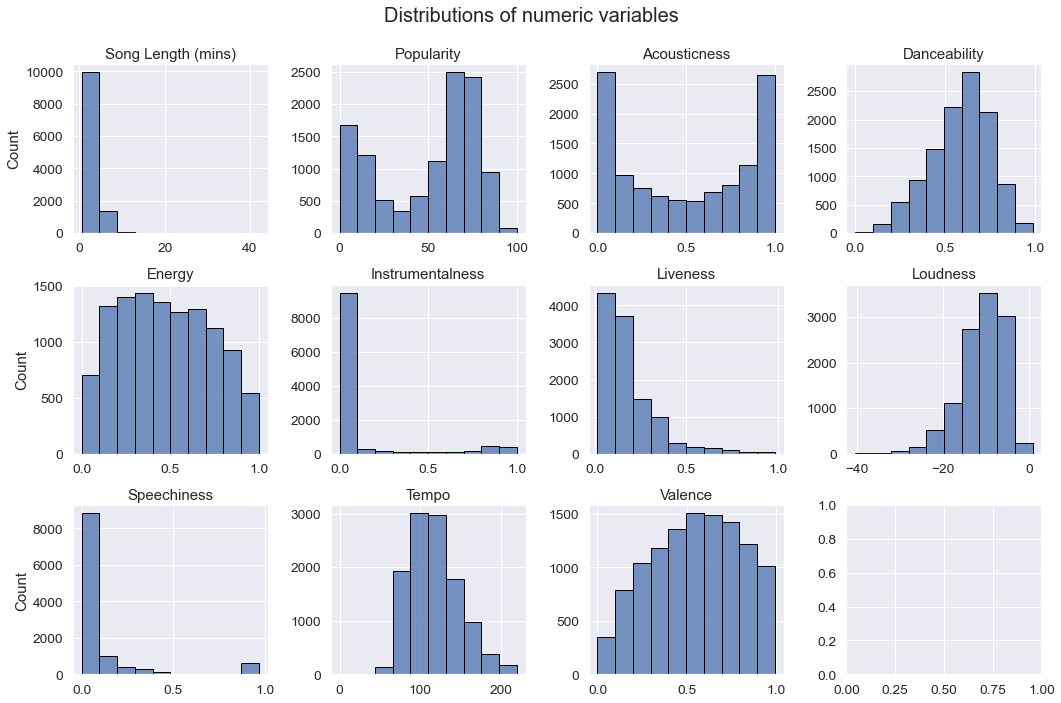

In [22]:
fig, ax = plt.subplots(3, 4, figsize = (15,10))
sns.histplot(x = spotify_dataset['song length (mins)'], bins = 10, edgecolor = 'black', ax=ax[0,0]), ax[0,0].set(title='Song Length (mins)', xlabel = "")
sns.histplot(x = spotify_dataset['popularity'], bins = 10, edgecolor = 'black', ax=ax[0,1]), ax[0,1].set(title='Popularity', xlabel = "", ylabel = "")
sns.histplot(x = spotify_dataset['acousticness'], bins = 10, edgecolor = 'black', ax=ax[0,2]), ax[0,2].set(title='Acousticness', xlabel = "", ylabel = "")
sns.histplot(x = spotify_dataset['danceability'], bins = 10, edgecolor = 'black', ax=ax[0,3]), ax[0,3].set(title='Danceability', xlabel = "", ylabel = "")
sns.histplot(x = spotify_dataset['energy'], bins = 10, edgecolor = 'black', ax=ax[1,0]), ax[1,0].set(title='Energy', xlabel = "")
sns.histplot(x = spotify_dataset['instrumentalness'], bins = 10, edgecolor = 'black', ax=ax[1,1]), ax[1,1].set(title='Instrumentalness', xlabel = "", ylabel = "")
sns.histplot(x = spotify_dataset['liveness'], bins = 10, edgecolor = 'black', ax=ax[1,2]), ax[1,2].set(title='Liveness', xlabel = "", ylabel = "")
sns.histplot(x = spotify_dataset['loudness'], bins = 10, edgecolor = 'black', ax=ax[1,3]), ax[1,3].set(title='Loudness', xlabel = "", ylabel = "")
sns.histplot(x = spotify_dataset['speechiness'], bins = 10, edgecolor = 'black', ax=ax[2,0]), ax[2,0].set(title='Speechiness', xlabel = "")
sns.histplot(x = spotify_dataset['tempo'], bins = 10, edgecolor = 'black', ax=ax[2,1]), ax[2,1].set(title='Tempo', xlabel = "", ylabel = "")
sns.histplot(x = spotify_dataset['valence'], bins = 10, edgecolor = 'black', ax=ax[2,2]), ax[2,2].set(title='Valence', xlabel = "", ylabel = "")

fig.tight_layout()

plt.suptitle("Distributions of numeric variables", size = 20)

fig.subplots_adjust(top=0.9)

#plt.show()

Observations:
- Song length is almost exclusively below 10 minutes, need further exploration to check values over this.
- Popularity not distributed that evenly with  most common scores between 60-80, but 0-10 the next most common after that.
- Acousticness is often very high (>0.9) or very low (<0.1)
- Instrumentalness and speechiness are mostly very low (less than 0.1).
- There is some very loud songs of up to 40 decibels, needs further investigation.
- Valence is pretty equally distributed, slightly more positive than negative.

**Outliers**

There will not be any outliers in metrics that have pre-defined ranges like popularity (0-100), or any of the calculated metrics which lie between 0 and 1. We therefore look at the continuous variables: song length, loudness, and tempo, starting by plotting a boxplot for each.

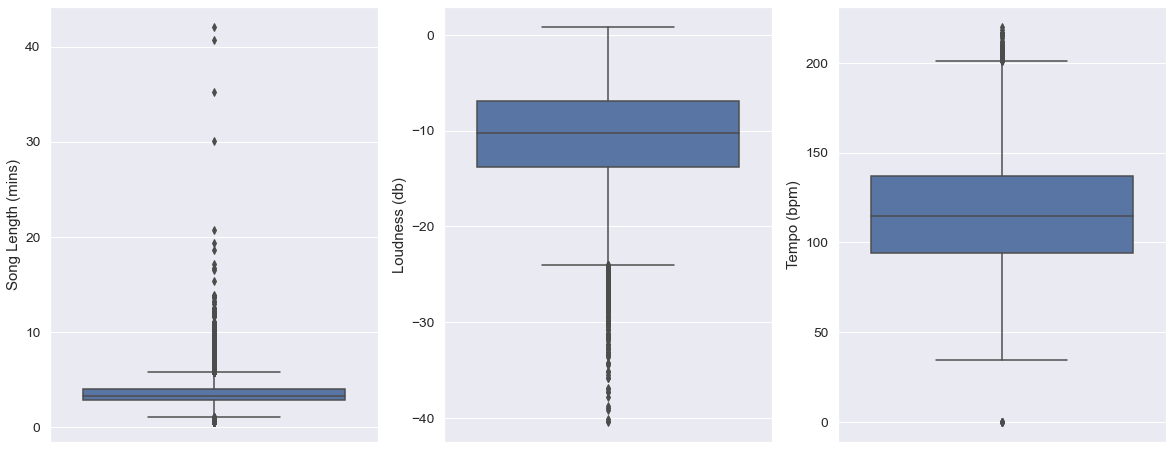

In [23]:
fig, ax = plt.subplots(1, 3, figsize = (20, 8))

sns.boxplot(y = spotify_dataset['song length (mins)'], ax=ax[0]), ax[0].set(ylabel = "Song Length (mins)")
sns.boxplot(y = spotify_dataset['loudness'], ax=ax[1]), ax[1].set(ylabel = "Loudness (db)")
sns.boxplot(y = spotify_dataset['tempo'], ax=ax[2]), ax[2].set(ylabel = "Tempo (bpm)")

plt.show()

The boxplot for song length shows that there are a number of longer songs over the upper whisker of around seven minutes, and a few extremely long songs of over 30 minutes. To check this we first identify the mean and standard deviation of song length, using the 3 sigma rule to identify what we should class as outliers.

In [29]:
song_length_mean = spotify_dataset['song length (mins)'].mean()
song_length_sd = spotify_dataset['song length (mins)'].std()
(print("Song Length Mean: ", song_length_mean, "Song Length SD:", song_length_sd))

sl_outliers_UB = song_length_mean+3*song_length_sd
sl_outliers_LB = song_length_mean-3*song_length_sd
(print("Song Length Upper Bound: ", sl_outliers_UB, "Song Length Lower Bound:", sl_outliers_LB))

# Subset to song lengths greater than 7.9 minutes
spotify_dataset[spotify_dataset['song length (mins)'] > sl_outliers_UB ] 

Song Length Mean:  3.4840677483094686 Song Length SD: 1.4788851621849202
Song Length Upper Bound:  7.92072323486423 Song Length Lower Bound: -0.9525877382452923


,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
1004,1910-1919,Ludwig van Beethoven,"Violin Sonata in A Major No. 9, Op. 47 ""Kreutz...",1Nlajo81JRjPyan1lj0k3I,1917,10.103767,False,27,0.973000,0.410,0.1990,0.438000,9.0,0.0396,-14.454,0.0,0.0589,79.513,4.0,0.1360
1005,1910-1919,Ludwig van Beethoven,"Violin Concerto in D Major, Op. 61: II. Larghetto",737JkPjECdA6ovDB2tVyzS,1917,8.754667,False,24,0.810000,0.185,0.0446,0.070200,7.0,0.3620,-29.453,1.0,0.0452,100.963,4.0,0.0476
1007,1910-1919,Ludwig van Beethoven,"Violin Concerto in D Major, Op. 61: III. Rondo...",6KnRJ01itdWnLAwjZRUi8T,1917,8.365550,False,24,0.870000,0.404,0.0913,0.171000,2.0,0.2160,-20.861,1.0,0.0427,94.354,4.0,0.4080
1008,1910-1919,Ludwig van Beethoven,"Violin Concerto in D Major, Op. 61: I. Allegro...",7bPfZ6VVhZASf5Aljm6NMn,1917,20.656667,False,24,0.880000,0.297,0.0959,0.042400,2.0,0.0877,-21.114,1.0,0.0422,106.647,4.0,0.1890
1018,1910-1919,Ludwig van Beethoven,"Romance No. 2, Op. 50, in F",6ruwzUYQU825uM54dNnTAb,1917,7.994000,False,7,0.876000,0.271,0.2150,0.198000,5.0,0.2590,-14.495,1.0,0.0389,104.856,4.0,0.1430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10486,2000-2009,Green Day,Holiday / Boulevard of Broken Dreams,0MsrWnxQZxPAcov7c74sSo,2004-09-21,8.223333,True,73,0.000659,0.290,0.8270,0.000003,8.0,0.3010,-3.451,1.0,0.0362,167.086,4.0,0.4500
11342,2010-2019,Kanye West,Runaway,3DK6m7It6Pw857FcQftMds,2010-11-22,9.128883,True,79,0.219000,0.374,0.5680,0.002190,1.0,0.5130,-3.825,0.0,0.1090,84.733,4.0,0.1110
11810,2010-2019,Justin Timberlake,Mirrors,4rHZZAmHpZrA3iH5zx8frV,2013-03-15,8.069100,False,81,0.234000,0.574,0.5120,0.000000,5.0,0.0946,-6.664,0.0,0.0503,76.899,4.0,0.5120
12004,2020-2029,Taylor Swift,All Too Well (10 Minute Version) (Taylor's Ver...,5enxwA8aAbwZbf5qCHORXi,2021-11-12,10.217100,True,94,0.274000,0.631,0.5180,0.000000,0.0,0.0880,-8.771,1.0,0.0303,93.023,4.0,0.2050


Can now see that a significant proportion of songs over eight minutes are from the early 20th century, with several from the very famous classical composer Beethoven. Longer songs are not uncommon in classical music so we are happy to these are not mistakes and keep them in the analysis. However, we need to look at the songs over 30 minutes in greater detail.

In [30]:
spotify_dataset[spotify_dataset['song length (mins)'] > 30 ] 

,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
3531,1930-1939,Franz Liszt,"Piano Sonata in B Minor, S. 178",6Zy82cYdN3x9ktUpQxHydk,1930,30.054667,False,17,0.979,0.310,0.220,0.8680,6.0,0.162,-16.664,1.0,0.0428,79.903,4.0,0.0634
3552,1930-1939,Umm Kulthum,Howa Saheeh El Hawa Ghallab,2YPHHTBrrq6CN8BDVIgDQc,1937-01-01,40.726667,False,24,0.890,0.338,0.364,0.0692,7.0,0.982,-10.873,1.0,0.0438,125.332,4.0,0.1990
3587,1930-1939,Umm Kulthum,Esaal Rouhak,4DCTCIw1KadSOOkzSm6aqM,1937-01-01,42.088217,False,24,0.895,0.368,0.397,0.1920,1.0,0.938,-10.796,1.0,0.0598,102.306,4.0,0.3080
4996,1940-1949,Umm Kulthum,Ana Fe Entezarak,21ExIYNPMskVNs61SbalQz,1943-01-01,35.191333,False,23,0.646,0.401,0.486,0.0313,1.0,0.668,-9.218,0.0,0.0655,104.807,4.0,0.2420


Whilst these are extreme outliers, there does not appear to be any reason that they should not be included, so are left for now.

The boxplot for loudness confirms that there are a number of sons below the lower whisker of around 25 decibels.

In [32]:
loudness_mean = spotify_dataset['loudness'].mean()
loudness_sd = spotify_dataset['loudness'].std()
(print("Loudness Mean: ", loudness_mean, "Loudness SD:", loudness_sd))

ld_outliers_UB = loudness_mean+3*loudness_sd
ld_outliers_LB = loudness_mean-3*loudness_sd 
(print("Loudness Upper Bound: ", ld_outliers_UB, "Loudness Lower Bound:", ld_outliers_LB))

# Subset to loudness less than 26.8 decibels
spotify_dataset[spotify_dataset['loudness'] < ld_outliers_LB ] 

Loudness Mean:  -10.974811802933136 Loudness SD: 5.291430730229478
Loudness Upper Bound:  4.899480387755297 Loudness Lower Bound: -26.84910399362157


,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
1005,1910-1919,Ludwig van Beethoven,"Violin Concerto in D Major, Op. 61: II. Larghetto",737JkPjECdA6ovDB2tVyzS,1917,8.754667,False,24,0.810,0.185,0.04460,0.070200,7.0,0.3620,-29.453,1.0,0.0452,100.963,4.0,0.04760
1015,1910-1919,Nikolai Rimsky-Korsakov,The Flight Of The Bumblebee,3hmPEiZ1vRCabtELE5qPNj,1919,1.161550,False,13,0.993,0.383,0.05070,0.743000,2.0,0.6360,-27.107,0.0,0.0596,94.853,4.0,0.52800
1024,1910-1919,Christoph Willibald Gluck,Melodie,55CmzcUEhlOv2jgpRafDTB,1919,3.434000,False,9,0.989,0.289,0.01630,0.001820,2.0,0.1240,-27.609,0.0,0.0419,76.959,4.0,0.15000
1033,1910-1919,Frédéric Chopin,"Nocturne in E-Flat Major, Op. 9, No. 2",1aq9cUtZijFZnoELCeBEjj,1919,4.705100,False,7,0.984,0.366,0.02170,0.000698,3.0,0.4050,-28.029,1.0,0.0395,104.173,4.0,0.13600
1041,1910-1919,Robert Schumann,"Carnaval, Op. 9: Chopin - 1989 Remastered Version",5qhWN5LpX94A5SXpmPk24L,1919,0.753767,False,5,0.991,0.252,0.01370,0.863000,8.0,0.0772,-31.679,1.0,0.0338,85.920,3.0,0.22900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11196,2010-2019,White Noise Baby Sleep,Clean White Noise - Loopable with no fade,2bRKxuH1o7pTmb1y4GfdEc,2017-01-08,1.503800,False,86,0.791,0.000,0.00342,1.000000,8.0,0.1110,-28.460,1.0,0.0000,0.000,0.0,0.00000
11426,2010-2019,Granular,White Noise - 145 hz,6H4B9gJD6eQlNoEh8q85pP,2017-10-13,2.258050,False,77,0.944,0.000,0.00002,0.869000,2.0,0.1120,-40.449,0.0,0.0000,0.000,0.0,0.00000
11447,2010-2019,Granular,White Noise - 500 hz,65rkHetZXO6DQmBh3C2YtW,2017-10-13,2.451600,False,78,0.923,0.000,0.00005,0.297000,10.0,0.1100,-32.354,0.0,0.0000,0.000,0.0,0.00000
12405,2020-2029,ame,raining for hours,3L1JHXiqNOJ57w3n2R3HyU,2021-08-13,2.191667,False,79,0.152,0.231,0.97600,0.987000,10.0,0.4800,-27.426,0.0,0.0487,96.552,5.0,0.00672


This subset appears to show a selection of classical songs again, which could reasonably be expected to be loud so there is no reason to remove them. However, there are a number of recent songs which are 'white noise'. As we are looking to analyse songs, these could be removed, but note that they also have a tempo of 0 which will be examined now.

The tempo boxplot appears to show a very low outlier which suggests one or more songs with a tempo of 0 beats per minute. We subset the dataset to examine this, because this should not be possible for a song where there is sound.

In [33]:
tempo_mean = spotify_dataset['tempo'].mean()
tempo_sd = spotify_dataset['tempo'].std()
(print("Tempo Mean: ", tempo_mean, "Tempo SD:", tempo_sd))

tmp_outliers_UB = tempo_mean+3*tempo_sd
tmp_outliers_LB = tempo_mean-3*tempo_sd 
(print("Tempo Upper Bound: ", tmp_outliers_UB, "Tempo Lower Bound:", tmp_outliers_LB))

# Subset to tempo less than 23.7 beats per minute
spotify_dataset[spotify_dataset['tempo'] < tmp_outliers_LB ] 

Tempo Mean:  117.88539589004985 Tempo SD: 31.41101830904372
Tempo Upper Bound:  212.11845081718099 Tempo Lower Bound: 23.6523409629187


,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
3400,1930-1939,MGM Studio Orchestra,Munchkinland Insert - Alternate Tag,1ysFtAdl7n8uB6uLCAsUNj,1939-08-25,0.545100,False,17,0.977,0.0,0.22300,0.010800,5.0,0.337,-19.146,0.0,0.0,0.0,0.0,0.0
3461,1930-1939,Bert Lahr,If I Were King of the Forest - Partial Take; A...,7tVDEvPqfx9bu2gIrbWx6z,1939-08-25,0.747333,False,15,0.951,0.0,0.13000,0.000007,10.0,0.766,-20.510,1.0,0.0,0.0,0.0,0.0
3473,1930-1939,Billie Holiday,Back In Your Own Backyard - Take 1,09eDRV4nzC3eVX7tDEJUNb,1937,2.660000,False,15,0.890,0.0,0.28100,0.000000,10.0,0.247,-13.078,1.0,0.0,0.0,0.0,0.0
4834,1940-1949,Charlie Parker,"Embraceable You - Live At Carnegie Hall, New Y...",4DGS6afG3cS3Ql1lbOeirB,1949,10.584433,False,12,0.980,0.0,0.09470,0.778000,5.0,0.861,-16.371,1.0,0.0,0.0,0.0,0.0
11196,2010-2019,White Noise Baby Sleep,Clean White Noise - Loopable with no fade,2bRKxuH1o7pTmb1y4GfdEc,2017-01-08,1.503800,False,86,0.791,0.0,0.00342,1.000000,8.0,0.111,-28.460,1.0,0.0,0.0,0.0,0.0
11426,2010-2019,Granular,White Noise - 145 hz,6H4B9gJD6eQlNoEh8q85pP,2017-10-13,2.258050,False,77,0.944,0.0,0.00002,0.869000,2.0,0.112,-40.449,0.0,0.0,0.0,0.0,0.0
11447,2010-2019,Granular,White Noise - 500 hz,65rkHetZXO6DQmBh3C2YtW,2017-10-13,2.451600,False,78,0.923,0.0,0.00005,0.297000,10.0,0.110,-32.354,0.0,0.0,0.0,0.0,0.0
12583,2020-2029,Water Sound Natural White Noise,Deep Sleep Recovery Noise,5pGBDKBaR63vuJ4g8ialcU,2020-02-25,1.050000,False,77,0.916,0.0,0.03200,0.202000,1.0,0.103,-30.704,1.0,0.0,0.0,0.0,0.0


There are eight songs with a tempo of 0, four of which are featured in the loudness outliers from the previous step. Three of these are 'white noise' tracks, and one is a sleeping aid. We are looking to analyse songs so remove these from the data.

In [34]:
spotify_dataset = spotify_dataset[spotify_dataset['tempo'] > 0]

In [35]:
# Subset to decibal loudness more than 212 beats per minute
high_tempo = spotify_dataset[spotify_dataset['tempo'] > tmp_outliers_UB ] 

high_tempo

,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
1193,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To Grace - Normal,3gISQ2yMPmEmaO44Kz3xS7,1912,0.534817,False,0,0.6270,0.621,0.390,0.057200,5.0,0.0772,-11.173,1.0,0.0461,215.801,3.0,0.576
1201,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To Jeffery - Traditional,4NEkPdLT9a5fUBmzHJXNDT,1912,0.536183,False,0,0.7270,0.644,0.459,0.000347,5.0,0.2660,-11.386,1.0,0.0572,216.043,3.0,0.521
1221,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To Louis - Normal,1tZaXe1Aj4LBVYPbda4U3i,1912,0.534817,False,0,0.6600,0.630,0.377,0.233000,5.0,0.0760,-11.154,1.0,0.0413,215.981,3.0,0.559
1231,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To Zoey - Traditional,6lu9xMmV40zhotM9UpMS9W,1912,0.536183,False,0,0.7010,0.632,0.479,0.004640,5.0,0.2560,-11.372,1.0,0.0570,215.965,3.0,0.505
1254,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To Ben - Traditional,0oKqts5RFTFiQ2b44YH65I,1912,0.536183,False,0,0.7320,0.624,0.464,0.004550,5.0,0.2480,-11.367,1.0,0.0569,215.834,3.0,0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To Roberto - Traditional,5bKUQI4LwxQBVWByNGwsSp,1912,0.536183,False,0,0.7290,0.627,0.466,0.015400,5.0,0.2280,-11.354,1.0,0.0558,215.918,3.0,0.511
1975,1910-1919,Happy Birthday All Names & Genres,Happy Birthday To David - Normal,0Et3Ctw5ZVzBCRBhhNbQIW,1912,0.534817,False,0,0.6700,0.637,0.387,0.096200,5.0,0.0762,-11.158,1.0,0.0415,216.076,3.0,0.576
4777,1940-1949,Bunk Johnson,Tiger Rag,1kl0XDY0NdCJugYOcx3m3e,1944-11-26,4.004667,False,15,0.9930,0.525,0.654,0.916000,3.0,0.0990,-8.125,1.0,0.2840,218.412,4.0,0.966
10922,2000-2009,Tony Dize,Permitame,0X5jHsNHshuHNfAWs1sxQ5,2008-01-01,3.083550,False,70,0.0287,0.629,0.668,0.000000,8.0,0.1590,-6.974,1.0,0.1500,214.025,4.0,0.904


Looking at rows in the data with tempo of over 212 beats per minute, we see a strange selection of 'Happy Birthday' songs in the 1910-1919 decade. We do a value count to see how many of the tempo high outliers these make up for.

In [36]:
high_tempo.value_counts('artist')

artist
Happy Birthday All Names & Genres    60
Bunk Johnson                          1
Tony Dize                             1
YNW Melly                             1
dtype: int64

We see that these make up 60 of the 64 high tempo outliers. By looking at the other metrics for the happy birthday songs, we can see that they score very similarly on all other metrics, differing slightly on if it is a 'normal' or 'traditional' happy birthday song. These are essentially duplicates in the data, so we remove them.

In [37]:
spotify_dataset = spotify_dataset[spotify_dataset['tempo'] < 212]

We now check for any obvious relationships within the numeric data. To do this we create a matrix of Pearson product moment correlation coefficients. A value towards 1 indicates a strong positive correlation, and a value towards -1 a strong negative correlation. Values near 0 imply independence of variables. Using a heatmap means strong correlations can be easily indentified visually.

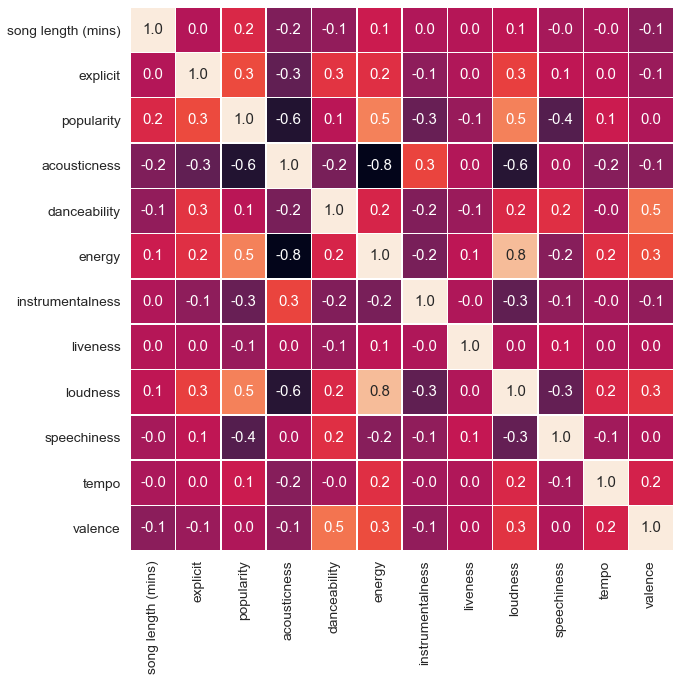

In [38]:
sns.set(font_scale = 1.25)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(spotify_dataset.corr(), annot=True, linewidths=.5, fmt = '.1f',ax=ax, cbar = False, square = True)
plt.show()

The heatmap shows several strong negative correlations, mostly for the acousticness variable with energy and loudness which makes sense, but also with popularity. There is a strong relationship between energy and loudness which also makes sense. These 2 variables most strongly correlate with popularity, which is something to explore. The other variable which has a small positive correlation with popularity is the explicitness of a song. We will investigate this to examine whether this is true.

**QUESTION 1:** 

On average, does a song being explicit increase or decrease its popularity?

In [39]:
# Split data into explicit and non-explicit
explicit = spotify_dataset[spotify_dataset['explicit'] == True]
non_explicit = spotify_dataset[spotify_dataset['explicit'] == False]

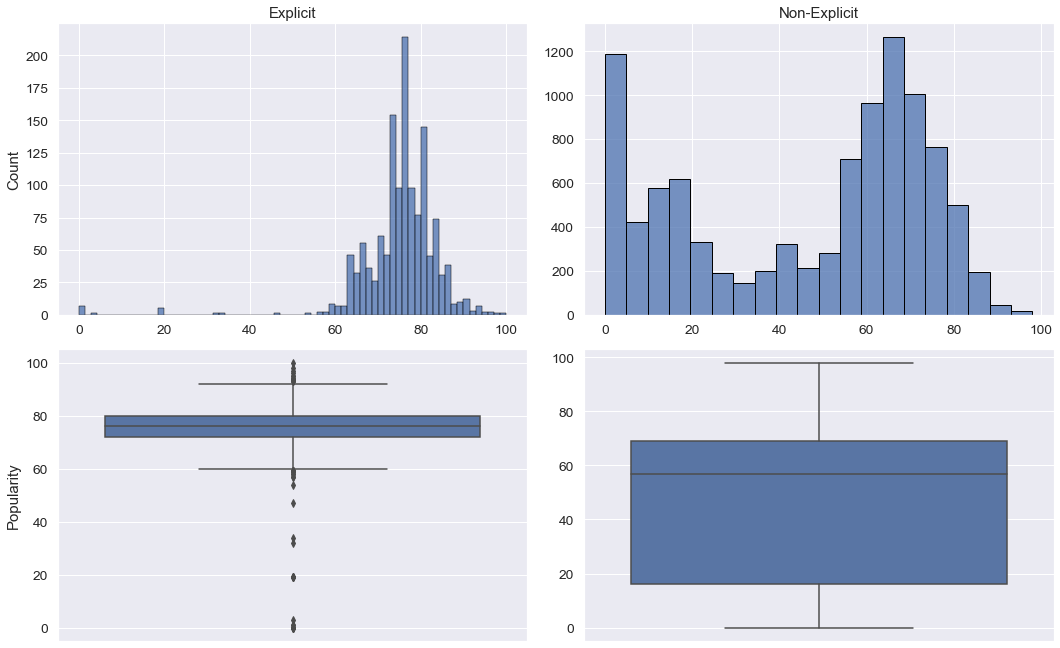

In [40]:
# Plot histograms and boxplots of each against popularity
fig, ax = plt.subplots(2, 2, figsize = (15,10))
sns.histplot(x = explicit['popularity'], edgecolor = 'black', ax=ax[0,0]), ax[0,0].set(title = 'Explicit', xlabel = "")
sns.histplot(x = non_explicit['popularity'], edgecolor = 'black', ax=ax[0,1]), ax[0,1].set(title = 'Non-Explicit', ylabel = "", xlabel = "")
sns.boxplot(y = explicit['popularity'], ax=ax[1,0]), ax[1,0].set(ylabel = "Popularity")
sns.boxplot(y = non_explicit['popularity'], ax=ax[1,1]), ax[1,1].set(title = "", ylabel = "")

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [41]:
explicit['popularity'].mean(), non_explicit['popularity'].mean()

(75.26153846153846, 46.01447090744649)

These plots appear to show that explicit songs are significantly more popular on average, with an explicit popularity mean of 75, against a non_explicit mean of 45, a large decrease.

However, the popularity metric is based on the current listening numbers of a song, and it is possible that an increasing proportion of songs are explicit in the modern day. We confirm this through a hypothesis test.

Hypothesis: An increasing proportion of songs are explicit in recent decades (since 1990).

p1 = proportion of explicit songs after 1990

p2 = proportion of explicit songs before 1990

null hypothesis H0: p1 - p2 = 0

alternate hypothesis Ha: p1 - p2 > 0

In [42]:
test_decades = ['1990-1999',
                '2000-2009',
                '2010-2019',
                '2020-2029']

spotify_recent = spotify_dataset[spotify_dataset['decade'].isin(test_decades) == True]
spotify_old = spotify_dataset[spotify_dataset['decade'].isin(test_decades) == False]

explicit_recent = explicit[explicit['decade'].isin(test_decades) == True]
explicit_old = explicit[explicit['decade'].isin(test_decades) == False]

In [43]:
number_a_1990 = len(spotify_recent)
number_b_1990 = len(spotify_old)

number_explicit_a_1990 = len(explicit_recent)
number_explicit_b_1990 = len(explicit_old)


test_statistic, p_value = sm.stats.proportions_ztest([number_explicit_a_1990, number_explicit_b_1990], 
                                                     [number_a_1990, number_b_1990],
                                                      alternative = 'larger')

In [44]:
print ("The test statistic is: ", test_statistic, "\n")
print ("The p-value is: ", p_value)

The test statistic is:  53.63411077832182 

The p-value is:  0.0


The p-value in this z-test of two independent proportions is 0.0, which is hugely strong statistical evidence that a greater proportion of songs are explicit in the decades after 1990 than before it.

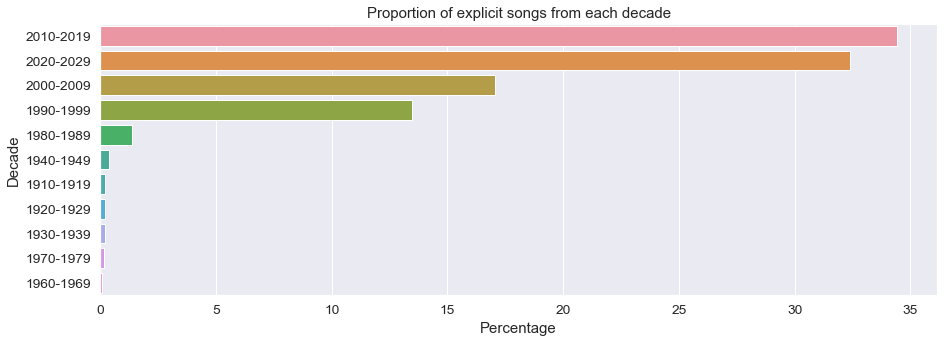

In [45]:
explicit_decade_counts_pct = (explicit['decade'].value_counts()/explicit['decade'].count())*100

plt.figure(figsize=(15,5))
sns.barplot(x=explicit_decade_counts_pct, y=explicit_decade_counts_pct.index)
plt.title("Proportion of explicit songs from each decade")
plt.ylabel("Decade")
plt.xlabel('Percentage');

A visualistion of the proportions from each individual decade also confirm the hypothesis. 

Subsequently to answer the question of its effect on popularity, we further reduce the data to compare the popularity of explicit vs non-explicit songs in more recent times choosing 1990-1999 as the cut off as this is when the proportion of songs that are explicit increased greatly.

In [46]:
explicit_decades = ['1990-1999',
                    '2000-2009',
                    '2010-2019',
                    '2020-2029']

explicit_recent = explicit[explicit['decade'].isin(explicit_decades)]

non_explicit_recent = non_explicit[non_explicit['decade'].isin(explicit_decades)]

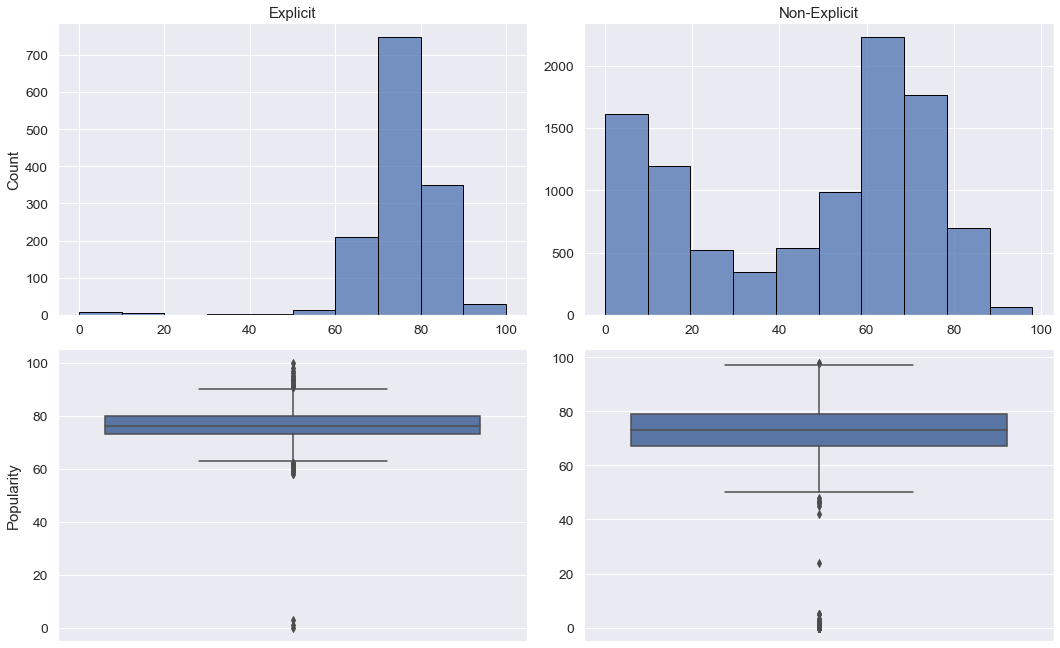

In [47]:
# Plot histograms and boxplots of each against popularity
fig, ax = plt.subplots(2, 2, figsize = (15,10))

sns.histplot(x = explicit['popularity'], bins = 10, edgecolor = 'black', ax=ax[0,0]), ax[0,0].set(title = 'Explicit', xlabel = "")
sns.histplot(x = non_explicit['popularity'], bins = 10, edgecolor = 'black', ax=ax[0,1]), ax[0,1].set(title = 'Non-Explicit', ylabel = "", xlabel = "")
sns.boxplot(y = explicit_recent['popularity'], ax=ax[1,0]), ax[1,0].set(ylabel = "Popularity")
sns.boxplot(y = non_explicit_recent['popularity'], ax=ax[1,1]), ax[1,1].set(title = "", ylabel = "")

fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

In [48]:
explicit_recent['popularity'].mean(), non_explicit_recent['popularity'].mean()

(75.98796087283672, 71.75205592105263)

Examining the histograms and boxplots again, subsetted on the four most recent decades shows much more similar distributions of popularity, although it appears that explicit songs still score slightly higher on popularity on average. 

We use a hypothesis test to confirm whether the mean of explicit songs is different to that of non-explicit songs within these recent decades.

Given the popularity scores of explicit and non-explicit songs in the last four decades, is there enough evidence to claim that explicit songs are more popular, on average, than non-explicit songs.

Hypothesis: Explicit songs score more highly on the Spotify popularity metric 

mu1 = mean popularity of explicit songs after 1990

mu2 = mean popularity of explicit songs before 1990

null hypothesis H0: mu1 - mu2 = 0

alternate hypothesis Ha: mu1 - mu2 > 0

In [49]:
from scipy import stats

stats.ttest_ind(explicit_recent['popularity'], non_explicit_recent['popularity'], 
               equal_var = 'False', alternative = 'greater')

Ttest_indResult(statistic=10.518453698202428, pvalue=8.006658647570308e-26)

This gives a miniscule p-value that is obviously smaller than 0.05. Consequently, we reject that the null hypothesis that there is no difference between the means given the samples.

We can now claim that a song being explicit does increase its popularity, on average.
released in the current age will score, on average, 4 more on the Spotify popularity metric than a non-explicit song. 

**QUESTION 2**

Which audio feature can best predict popularity by itself?

Whilst the earlier heatmap matrix gave some idea of the relationships between popularity and the numerical audio features variables, it would be helpful to plot these visually using scatter plots.

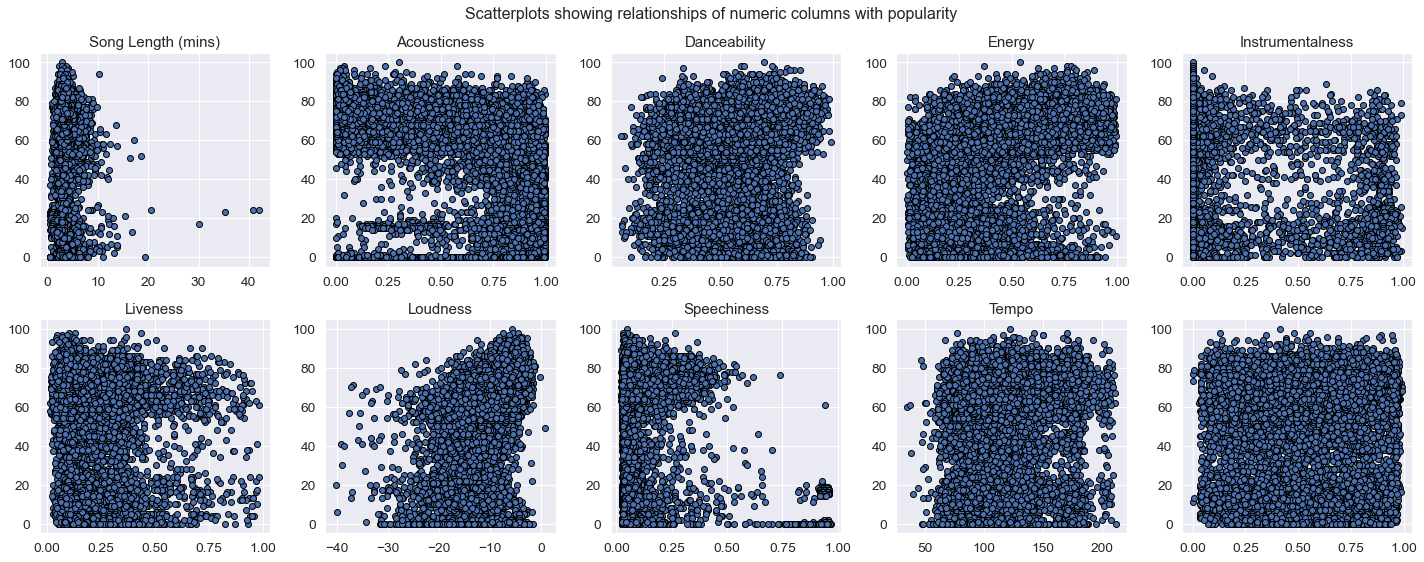

In [50]:
fig, ax = plt.subplots(2, 5, figsize = (20,8))
ax[0, 0].scatter(spotify_dataset['song length (mins)'], spotify_dataset['popularity'], edgecolor = 'black'), ax[0, 0].title.set_text('Song Length (mins)')
ax[0, 1].scatter(spotify_dataset['acousticness'], spotify_dataset['popularity'], edgecolor = 'black'), ax[0, 1].title.set_text('Acousticness')
ax[0, 2].scatter(spotify_dataset['danceability'], spotify_dataset['popularity'], edgecolor = 'black'), ax[0, 2].title.set_text('Danceability')
ax[0, 3].scatter(spotify_dataset['energy'], spotify_dataset['popularity'], edgecolor = 'black'), ax[0, 3].title.set_text('Energy')
ax[0, 4].scatter(spotify_dataset['instrumentalness'], spotify_dataset['popularity'], edgecolor = 'black'), ax[0, 4].title.set_text('Instrumentalness')
ax[1, 0].scatter(spotify_dataset['liveness'], spotify_dataset['popularity'], edgecolor = 'black'), ax[1, 0].title.set_text('Liveness')
ax[1, 1].scatter(spotify_dataset['loudness'], spotify_dataset['popularity'], edgecolor = 'black'), ax[1, 1].title.set_text('Loudness')
ax[1, 2].scatter(spotify_dataset['speechiness'], spotify_dataset['popularity'], edgecolor = 'black'), ax[1, 2].title.set_text('Speechiness')
ax[1, 3].scatter(spotify_dataset['tempo'], spotify_dataset['popularity'], edgecolor = 'black'), ax[1, 3].title.set_text('Tempo')
ax[1, 4].scatter(spotify_dataset['valence'], spotify_dataset['popularity'], edgecolor = 'black'), ax[1, 4].title.set_text('Valence')

fig.tight_layout()
plt.suptitle("Scatterplots showing relationships of numeric columns with popularity", size = 16)
fig.subplots_adjust(top=0.9)



These scatter plots appear to match the matrix's values, with a slight positive correlation with energy and loudness, and a negative correlation with acousticness.

Whilst we have compared the correlations of the numeric variables, it is important to now also do so for the categorical variables. We have already found that the explicitness of a song does impact the popularity, although this only becomes apparent when looking at recent data.

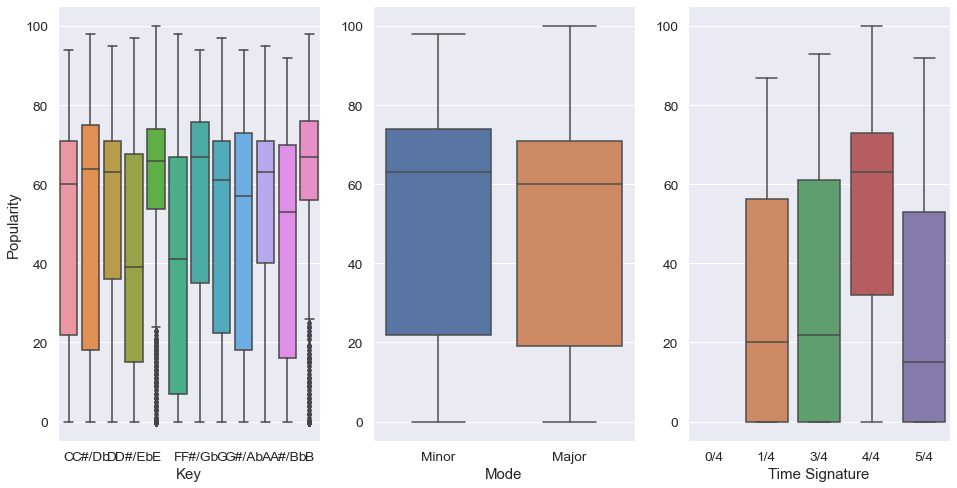

In [51]:
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
sns.boxplot(x = spotify_dataset['key'], y = spotify_dataset['popularity'], ax=ax[0]), ax[0].set(title = "", ylabel = "Popularity", xlabel = "Key", xticklabels = key_names.values())
sns.boxplot(x = spotify_dataset['mode'], y = spotify_dataset['popularity'], ax=ax[1]), ax[1].set(title = "", ylabel = "", xlabel = "Mode", xticklabels =('Minor', 'Major'))
sns.boxplot(x = spotify_dataset['time signature'], y = spotify_dataset['popularity'], ax=ax[2]), ax[2].set(title = "", ylabel = "", xlabel = "Time Signature", xticklabels = signature_names.values())

plt.show()

The E and B keys appear to score more highly than the other keys on popularity. There is not much difference between modes with a slight advantage for minor modality. The regular time signature of 4 beats per bar shows the highest average popularity, although it is also by far the most common.

**Regression model**

From the preliminary analyses, the variables acousticness, energy, loudness, keys E and B, and time signature 4 require further exploration. Therefore we put each of these into a simple linear regression model, with popularity as the target variable.

However, to do so correctly, we need to import utilise the train_test_split function. This is because the spotify dataset is currently ordered by decade, meaning that any midway split will result in a split of older and more recent songs. As we are looking to examine the effects of these variables irrelevant of the decade, we use train_test_split to shuffle up the dataset before it is split.

In [52]:
# train_test_split allows us to shuffle up the data, preventing the ordering by decades from affecting results.
from sklearn.model_selection import train_test_split

# test size parameter determines the split, 0.5 means halfway
train_df, test_df = train_test_split(spotify_dataset, test_size = 0.5, random_state = 40, shuffle = True)

We then create simple linear regressions for each variable, checking its R2 value to see how well it can
predict the variance of the target variable, popularity.

**Acousticness**

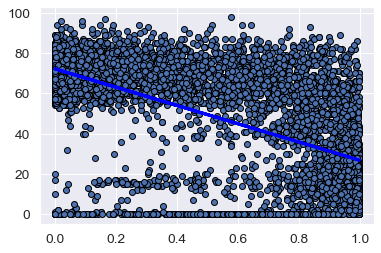

In [53]:
# Split the predictor into training/testing sets
acousticness_train = train_df['acousticness'].values.reshape(len(train_df),1)
acousticness_test = test_df['acousticness'].values.reshape(len(test_df),1)

# Split the target into training/testing sets
popularity_train = train_df['popularity'].values.reshape(len(train_df),1)
popularity_test = test_df['popularity'].values.reshape(len(test_df),1)

# Create linear regression model and fit it to data
ac_regr = LinearRegression() 

ac_regr.fit(acousticness_train, popularity_train)

# Make predictions using the testing set
popularity_pred = ac_regr.predict(acousticness_test)

# Plot outputs
plt.scatter(acousticness_test, popularity_test, edgecolor = 'black') 
plt.plot(acousticness_test, popularity_pred, color = "blue", linewidth=3)

plt.show()

In [54]:
print("Acousticness model slope:", ac_regr.coef_[0]) 
print("Acousticness model intercept:", ac_regr.intercept_)
print("Acousticness R2 Score:", ac_regr.score(acousticness_test, popularity_test))

Acousticness model slope: [-45.44390229]
Acousticness model intercept: [72.18897207]
Acousticness R2 Score: 0.3539766855201031


**Energy**

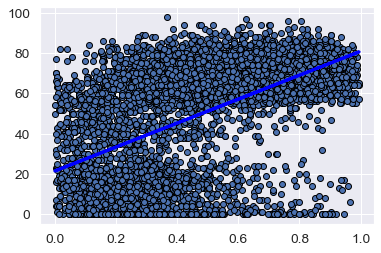

In [55]:
# Split the predictor into training/testing sets
energy_train = train_df['energy'].values.reshape(len(train_df),1)
energy_test = test_df['energy'].values.reshape(len(test_df),1)

# Split the targets into training/testing sets
popularity_train = train_df['popularity'].values.reshape(len(train_df),1)
popularity_test = test_df['popularity'].values.reshape(len(test_df),1)

# Create linear regression model and fit it to data
en_regr = LinearRegression() 
en_regr.fit(energy_train, popularity_train)

# Make predictions using the testing set
popularity_pred = en_regr.predict(energy_test)

# Plot outputs
plt.scatter(energy_test, popularity_test, edgecolor = 'black') 
plt.plot(energy_test, popularity_pred, color = "blue", linewidth=3)

plt.show()

In [56]:
print("Energy model slope:", en_regr.coef_[0]) 
print("Energy model intercept:", en_regr.intercept_)
print("Energy R2 Score:", en_regr.score(energy_test, popularity_test))

Energy model slope: [59.43063408]
Energy model intercept: [21.47326096]
Energy R2 Score: 0.28062670229601683


**Loudness**

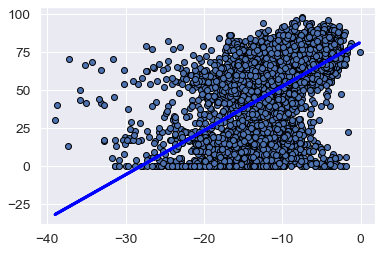

In [57]:
# Split the predictor into training/testing sets
loudness_train = train_df['loudness'].values.reshape(len(train_df),1)
loudness_test = test_df['loudness'].values.reshape(len(test_df),1)

# Split the target into training/testing sets
popularity_train = train_df['popularity'].values.reshape(len(train_df),1)
popularity_test = test_df['popularity'].values.reshape(len(test_df),1)

# Create linear regression model and fit it to data
ld_regr = LinearRegression() 
ld_regr.fit(loudness_train, popularity_train)

# Make predictions using the testing set
popularity_pred = ld_regr.predict(loudness_test)

# Plot outputs
plt.scatter(loudness_test, popularity_test, edgecolor = 'black') 
plt.plot(loudness_test, popularity_pred, color="blue", linewidth = 3)

plt.show()

In [58]:
print("Loudness model slope:", ld_regr.coef_[0]) 
print("Loudness model intercept:", ld_regr.intercept_)
print("Loudness R2 Score:", ld_regr.score(loudness_test, popularity_test))

Loudness model slope: [2.90612196]
Loudness model intercept: [81.25967263]
Loudness R2 Score: 0.2817429674172518


Now we attempt to look at the effects of the desired levels of the categorical variables. To do so, we need to make dummy variables with the argument drop_first = True, which allows us to look at the effect of each key in comparison with the 'dropped' key, which is the key encoded as 0 - C.

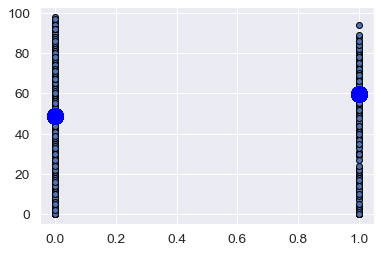

In [59]:
# Split the categorical variables into dummies of each level within the category
train_df_key_dummies = pd.get_dummies(data=train_df['key'], drop_first=True)
test_df_key_dummies = pd.get_dummies(data=test_df['key'], drop_first=True)

# Split the predictor into training/testing sets
E_key_train = train_df_key_dummies[4].values.reshape(len(train_df),1)
E_key_test = test_df_key_dummies[4].values.reshape(len(test_df),1)

# Split the target into training/testing sets
popularity_train = train_df['popularity'].values.reshape(len(train_df),1)
popularity_test = test_df['popularity'].values.reshape(len(test_df),1)

# Create linear regression model and fit it to data
E_key_regr = LinearRegression() 
E_key_regr.fit(E_key_train, popularity_train)

# Make predictions using the testing set
popularity_pred = E_key_regr.predict(E_key_test)

# Plot outputs
plt.scatter(E_key_test, popularity_test, edgecolor = 'black') 
# Represent predictions with a large blue point
plt.scatter(E_key_test, popularity_pred, color="blue", edgecolor = 'blue',linewidth=10)

plt.show()

In [60]:
print("E key model slope:", E_key_regr.coef_[0]) 
print("E key model intercept:", E_key_regr.intercept_)
print("E key R2 Score:", E_key_regr.score(E_key_test, popularity_test))

E key model slope: [10.83853851]
E key model intercept: [48.61764706]
E key R2 Score: 0.0024706216599359454


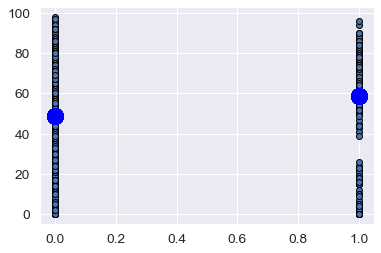

In [61]:
# Split the categorical variables into dummies of each level within the category
train_df_key_dummies = pd.get_dummies(data=train_df['key'], drop_first=True)
test_df_key_dummies = pd.get_dummies(data=test_df['key'], drop_first=True)

# Split the predictor into training/testing sets
B_key_train = train_df_key_dummies[11].values.reshape(len(train_df),1)
B_key_test = test_df_key_dummies[11].values.reshape(len(test_df),1)

# Split the target into training/testing sets
popularity_train = train_df['popularity'].values.reshape(len(train_df),1)
popularity_test = test_df['popularity'].values.reshape(len(test_df),1)

# Create linear regression model and fit it to data
B_key_regr = LinearRegression() 
B_key_regr.fit(B_key_train, popularity_train)

# Make predictions using the testing set
popularity_pred = B_key_regr.predict(B_key_test)

# Plot outputs
plt.scatter(B_key_test, popularity_test, edgecolor = 'black')
# Represent predictions with a large blue point
plt.scatter(B_key_test, popularity_pred, color="blue", edgecolor = 'blue',linewidth=10)

plt.show()

In [62]:
print("B key model slope:", B_key_regr.coef_[0]) 
print("B key model intercept:", B_key_regr.intercept_)
print("B key R2 Score:", B_key_regr.score(B_key_test, popularity_test))

B key model slope: [9.65795269]
B key model intercept: [48.84369748]
B key R2 Score: 0.0041629307074294575


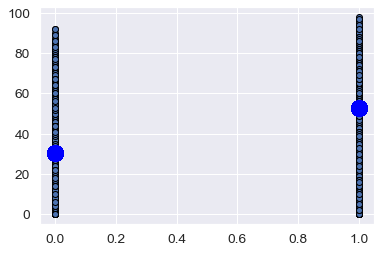

In [63]:
# Split the categorical variables into dummies of each level within the category
train_df_ts_dummies = pd.get_dummies(data=train_df['time signature'], drop_first=True)
test_df_ts_dummies = pd.get_dummies(data=test_df['time signature'], drop_first=True)

# Split the predictor into training/testing sets
ts_4_train = train_df_ts_dummies[4].values.reshape(len(train_df),1) #11th key is final one: B
ts_4_test = test_df_ts_dummies[4].values.reshape(len(test_df),1)

# Split the targets into training/testing sets
popularity_train = train_df['popularity'].values.reshape(len(train_df),1)
popularity_test = test_df['popularity'].values.reshape(len(test_df),1)

# Create linear regression model and fit it to data
ts_4_regr = LinearRegression() 
ts_4_regr.fit(ts_4_train, popularity_train)

# Make predictions using the testing set
popularity_pred = ts_4_regr.predict(ts_4_test)

# Plot outputs
plt.scatter(ts_4_test, popularity_test, edgecolor = 'black') 
# Represent predictions with a large blue point
plt.scatter(ts_4_test, popularity_pred, color="blue", edgecolor = 'blue',linewidth=10)

plt.show()

In [64]:
print("Time signature 4/4 model slope:", ts_4_regr.coef_[0]) 
print("Time signature 4/4 model intercept:", ts_4_regr.intercept_)
print("Time signature 4/4 R2 Score:", ts_4_regr.score(ts_4_test, popularity_test))

Time signature 4/4 model slope: [22.23387202]
Time signature 4/4 model intercept: [30.59297052]
Time signature 4/4 R2 Score: 0.07839505302506278


Whilst the three categorical variables tested do have influence on popularity against their reference value, they
do not score well on the R2 value at below 0.1 each. The acousticness variable of a song had the greatest score at 0.36. Although this is not that strong, it does emphasise a reasonable relationship, so artists looking to increase the popularity of their songs should stear clear of acoustic instruments.

Can the R2 score, representing the variance explained by a model, be improved by including multiple of these variables in a linear model?

In [65]:
multiple_vars_train = train_df[['acousticness', 'loudness', 'energy']].values
multiple_vars_test = test_df[['acousticness', 'loudness', 'energy']].values

# Split the target into training/testing sets
popularity_train = train_df['popularity'].values.reshape(len(train_df),1)
popularity_test = test_df['popularity'].values.reshape(len(test_df),1)

regr_all = LinearRegression()
regr_all.fit(multiple_vars_train, popularity_train) 

vars_y_pred = regr_all.predict(multiple_vars_test)

In [66]:
print("Coefficients: ", regr_all.coef_, '\nintercept:', regr_all.intercept_) 

regr_all.score(multiple_vars_test, popularity_test)

Coefficients:  [[-36.29447629   1.88060933 -11.62313469]] 
intercept: [93.68934197]


0.4082915944194667

The R2 value of this multiple linear regression model is 0.41, a small but still significant improvement over just using acousticness on its own.

**Question 3** Can we create a model that can accurately predict whether a song has minor or major modality based on its features?

In [67]:
from sklearn.linear_model import LogisticRegression

model_logit = LogisticRegression()

predictors = ['song length (mins)', 'acousticness', 'danceability', 'energy', 'instrumentalness', 
              'liveness','loudness', 'speechiness', 'tempo', 'valence']

# split the data into testing and training sets
predictors_train = train_df[predictors].values 
mode_train = train_df['mode'].values

predictors_test = test_df[predictors].values 
mode_test = test_df['mode'].values

#Fit the model
model_logit.fit(predictors_train, mode_train) 

# Make predictions on unseen data
mode_predictions = model_logit.predict(predictors_test)

# Predict the score for the model
model_logit.score(predictors_test, mode_test)

0.7177447861435136

This represents the accuracy of the model, defined as the the number of correct predictions made by the model divided by the total number of predictions. Coincidentally it matches up exactly with the proportion of major songs in the dataset, so around 72% of the 72% of songs that are major were predicted correctly.

As the project ran out of time, further steps to include the categorical variables as dummies in the predictors could not be taken.

### Summary

This project involved stages of retrieving, cleaning, and analysing spotify data. It was very helpful to work through these steps in detail, seeing the importance between the earlier stages and achieving insights from the data when analysing it later.

The analysis learned that a greater proportion of released songs are explicit in recent decades, and that this is actually associated with a small increase in popularity on average. Access to variables such as genre would allow us to drill down into whether this is specific to certain types of song.

Furthermore, we have looked at the influence of multiple numeric variables, and specific levels of categorical variables, on the popularity metric, finding that, in isolation, acousticness is most strongly correlated. This is a negative relationship, so those in the music industry looking to improve the reach of their songs on Spotify should ditch their guitars. It was also found that the model could be slightly improved by using the varibles tested in conjunction rather than by themselves.

Finally, a quick fitting of a logistic regression model found that, using all the numeric audio features, the model could offer above a 70% prediction of whether a song is in the major modality.

**Future Work**

Whilst the data used was sufficient, there are number of avenues for future analysis that could be done with access to other sources. Examples of variables that would be interesting to explore in combination wih the current ones are:
- Genre - What are the common audio features of each? Which have been most popular in different decades?
- Metrics describing popularity in the year of release (eg. highest chart placing) - This would allow for analysis of the audio features that made songs popular at different times.
- Type of artist eg Band/solo - Any key musical differences?
- Gender of artist - Preference for certain keys or modes?
- Nationality/language - How does culture affect the musical features?